In [1]:
import numpy as np
import pandas as pd

## Passo 1: Leitura dos dados
Leitura dos bancos de dados em DataFrame Pandas. 

In [2]:
caminho_dados_lazaro = 'Datasets/Lazaro/dados_pre_processados_lazaro.csv'

In [3]:
df = pd.read_csv(caminho_dados_lazaro)

In [4]:
df.head()

,Piquete,Altura real,Altura esperada,Animal,SensorID,Sensor Name,Date,X,Y,Z,Comportamento,Season_fall,Season_spring,Season_summer,magn,sma,ent,pit,rol,icl
0,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:47,-0.132,-0.583,0.712,Ocio,0.0,1.0,0.0,0.929654,1.427,-0.005973,8.162915,129.311311,40.014999
1,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:48,0.021,-0.792,0.574,Ocio,0.0,1.0,0.0,0.978356,1.387,-0.282943,-1.229924,144.067373,54.076939
2,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:50,0.021,-0.792,0.574,Ocio,0.0,1.0,0.0,0.978356,1.387,-0.282943,-1.229924,144.067373,54.076939
3,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:51,0.021,-0.792,0.574,Ocio,0.0,1.0,0.0,0.978356,1.387,-0.282943,-1.229924,144.067373,54.076939
4,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:52,-0.061,-0.870,0.478,Ocio,0.0,1.0,0.0,0.994538,1.409,-0.361029,3.516446,151.214493,61.273746


In [5]:
# Remove as linhas com o sensor 434138
df = df[df.SensorID != 434138]

## Passo 2: Treinamento

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Para a busca do melhores hiperparêmetros
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import gp_minimize

### Seleção de colunas aplicáveis

In [7]:
df.columns

Index(['Piquete', 'Altura real', 'Altura esperada', 'Animal', 'SensorID',
       'Sensor Name', 'Date', 'X', 'Y', 'Z', 'Comportamento', 'Season_fall',
       'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol',
       'icl'],
      dtype='object')

In [8]:
# Lista com os atributos aplicáveis
features_aplicaveis = ['X', 'Y' ,'Z', 'Comportamento', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']

# Seleciona os abributos correspondentes da lista features_aplicaveis
df = df[features_aplicaveis]

#### Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [9]:
y = df.Comportamento
X = df.drop('Comportamento', axis=1)

# Conjunto de dados PRO: Pastejando x Ruminando x Ócio
# Test size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [15]:
# Conjunto de dados PNP: Pastejando x Não Pastejando
y_pnp = y
y_pnp = y_pnp.replace(to_replace=['Ocio', 'Ruminando'], value='Não Pastejando')
X_train, X_test, y_train, y_test = train_test_split(X, y_pnp, random_state = 0)

### Função para imprimir e salvar matriz de confusão

In [13]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.0%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

### LGBMClassifier

In [19]:
from lightgbm import LGBMClassifier

In [20]:
lgb_model = LGBMClassifier(n_jobs=-1, random_state=0)
lgb_model.fit(X_train, y_train)

lgb_preds = lgb_model.predict(X_test)

accuracy_score(y_test, lgb_preds)*100

70.69860595040451

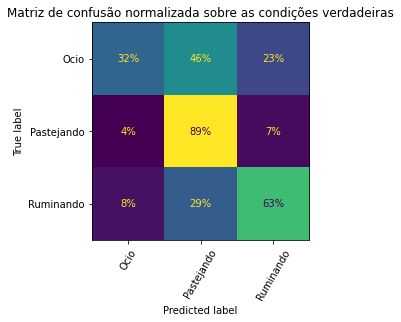

In [13]:
imprimeMatrizDeConfusão(y_test, lgb_preds, lgb_model)

#### LGB: Busca de melhores hiper parâmetros

In [24]:
def treinar_modelo_lgb(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params, '\n')
    
    lgb_Model = LGBMClassifier(learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree, random_state=0, subsample_freq=1, 
                         n_estimators=100)
    lgb_Model.fit(X_train, y_train)
    
    lgb_preds = lgb_Model.predict(X_test)
    
    return -accuracy_score(y_test, lgb_preds)*100

space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (2, 512), # num_leaves
         (1, 500), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0)] # colsample bytree

In [ ]:
resultados_lgb = gp_minimize(treinar_modelo_lgb, space, random_state=0, verbose=1, n_calls=50, n_random_starts=10, n_jobs=-1)

In [26]:
# Melhores hiper parâmetros para o conjunto PRO: learning_rate=0.1, num_leaves=362, min_child_samples=120, subsample=0.85, colsample_bytree=1.0, random_state=0

In [27]:
# Melhores hiper parâmetros para o conjunto PNP: learning_rate=0.04, num_leaves=512, min_child_samples=1, subsample=1.0, colsample_bytree=0.65, random_state=0

In [29]:
resultados_lgb.x

[0.1, 362, 120, 0.8489006092392756, 1.0]

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

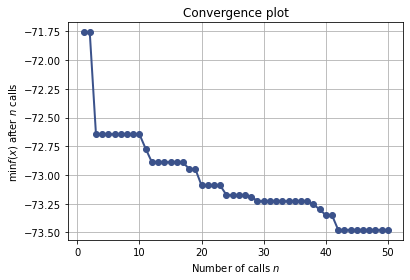

In [89]:
from skopt.plots import plot_convergence
plot_convergence(resultados_lgb)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

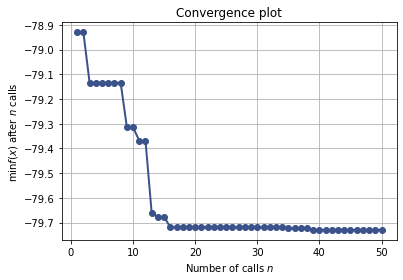

In [100]:
from skopt.plots import plot_convergence
plot_convergence(resultados_lgb)

In [21]:
lgb_model = LGBMClassifier(learning_rate=0.1, num_leaves=362, min_child_samples=120, subsample=0.85, colsample_bytree=1.0, random_state=0)
lgb_model.fit(X_train, y_train)

lgb_preds = lgb_model.predict(X_test)

accuracy_score(y_test, lgb_preds)*100

73.44190581600654

In [23]:
print(classification_report(y_test, lgb_preds))

              precision    recall  f1-score   support

        Ocio       0.64      0.40      0.50     30838
  Pastejando       0.77      0.89      0.83     83380
   Ruminando       0.69      0.66      0.67     37570

    accuracy                           0.73    151788
   macro avg       0.70      0.65      0.66    151788
weighted avg       0.72      0.73      0.72    151788



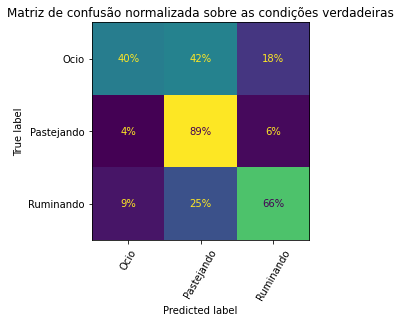

In [24]:
imprimeMatrizDeConfusão(y_test, lgb_preds, lgb_model)

In [25]:
lgb_preds = lgb_model.predict(X_train)

accuracy_score(y_train, lgb_preds)*100

75.90554328204813

### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

#### Com Randomized Search CV

In [39]:
rf_Model = RandomForestClassifier(random_state=0, n_jobs=-1)

In [40]:
# Create the param grid
rf_param_grid = {'n_estimators':  np.arange(50, 250, 50),
               'max_features': ['auto', 'sqrt'],
               'max_depth':[50, 100, 150, None],
               'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 5, 10, 30, 50],
               'min_samples_leaf': [1, 2],
               'bootstrap': [True, False]}

In [41]:
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = rf_param_grid, cv = 3, verbose=1, random_state=0)

In [ ]:
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [46]:
rf_RandomGrid.best_params_

{'n_estimators': 150,
 'min_samples_split': 30,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'criterion': 'entropy',
 'bootstrap': False}

In [48]:
rf_RandomGrid.best_score_

0.7361747363918738

In [50]:
preds_rf_RG = rf_RandomGrid.predict(X_test)

In [51]:
accuracy_score(y_test, preds_rf_RG)*100

74.09413128837589

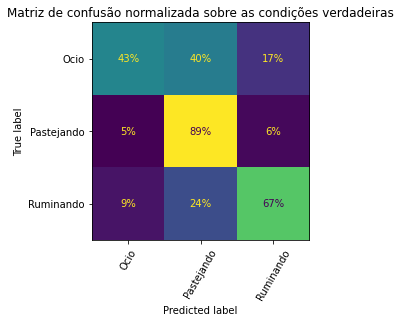

In [52]:
imprimeMatrizDeConfusão(y_test, preds_rf_RG, rf_RandomGrid)

#### Com Minimize

In [36]:
def treinar_modelo_rf(params):
    n_estimators = params[0]
    max_features = params[1]
    max_depth = params[2]
    criterion = params[3]
    min_samples_split = params[4]
    min_samples_leaf = params[5]
    bootstrap = params[6]
    
    print(params, '\n')
    
    rf_Model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, criterion=criterion, min_samples_split=min_samples_split,
                                      bootstrap=bootstrap, random_state=0, n_jobs=-1)
    
    rf_Model.fit(X_train, y_train)
    
    rf_preds = rf_Model.predict(X_test)
    
    return -accuracy_score(y_test, rf_preds)*100

space = [(16, 256), # n_estimators
         ['auto', 'sqrt'], # max_features
         (32, 128), # max_depth
         ['gini', 'entropy'], # criterion
         (0.1, 1.0), # min_samples_split
         [1,2], # min_samples_leaf
         [True, False]] # bootstrap] 

In [37]:
resultado_rf = gp_minimize(treinar_modelo_rf, space, random_state=0, verbose=1, n_calls=30, n_random_starts=15, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[158, 'sqrt', 114, 'gini', 0.6612073271073752, 1, False] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.6412
Function value obtained: -54.9319
Current minimum: -54.9319
Iteration No: 2 started. Evaluating function at random point.
[30, 'auto', 78, 'gini', 0.5319794551375517, 1, True] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.8811
Function value obtained: -54.9319
Current minimum: -54.9319
Iteration No: 3 started. Evaluating function at random point.
[97, 'sqrt', 67, 'gini', 0.22631570237138066, 2, False] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 10.5729
Function value obtained: -59.7412
Current minimum: -59.7412
Iteration No: 4 started. Evaluating function at random point.
[208, 'sqrt', 97, 'gini', 0.6238178128675965, 2, True] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 7.7394
Function value obtained: -54.9319
Current

/home/caio/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 41.0648
Function value obtained: -61.6274
Current minimum: -61.7315
Iteration No: 24 started. Searching for the next optimal point.
[74, 'sqrt', 128, 'entropy', 0.1, 1, False] 

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 12.7220
Function value obtained: -61.6860
Current minimum: -61.7315
Iteration No: 25 started. Searching for the next optimal point.
[16, 'sqrt', 128, 'entropy', 0.1, 1, False] 



/home/caio/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 3.5077
Function value obtained: -61.5477
Current minimum: -61.7315
Iteration No: 26 started. Searching for the next optimal point.
[187, 'auto', 128, 'entropy', 0.1, 2, False] 

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 29.7523
Function value obtained: -61.4541
Current minimum: -61.7315
Iteration No: 27 started. Searching for the next optimal point.
[256, 'sqrt', 32, 'gini', 0.1, 1, False] 

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 36.2822
Function value obtained: -61.7901
Current minimum: -61.7901
Iteration No: 28 started. Searching for the next optimal point.
[256, 'sqrt', 32, 'gini', 0.1, 1, False] 



/home/caio/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 36.2313
Function value obtained: -61.7901
Current minimum: -61.7901
Iteration No: 29 started. Searching for the next optimal point.
[16, 'sqrt', 32, 'entropy', 0.1, 2, False] 

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 3.7805
Function value obtained: -61.5477
Current minimum: -61.7901
Iteration No: 30 started. Searching for the next optimal point.
[256, 'sqrt', 32, 'gini', 0.1, 1, False] 



/home/caio/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 36.1866
Function value obtained: -61.7901
Current minimum: -61.7901


#### RF com os melhores parâmetros

In [34]:
model = RandomForestClassifier(n_estimators=150,
                              min_samples_split=30,
                              min_samples_leaf=1,
                              max_features='sqrt',
                              max_depth=100,
                              criterion='entropy',
                              bootstrap=False,
                              n_jobs=-1,
                              random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [35]:
accuracy_score(y_test, preds)*100

74.09413128837589

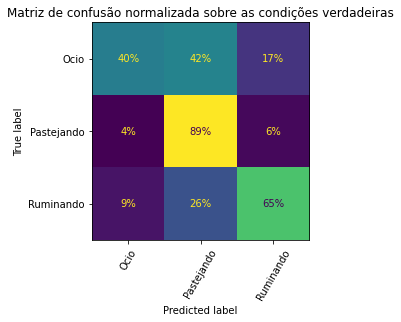

In [78]:
imprimeMatrizDeConfusão(y_test, preds, model)

### Gradient Boosting

In [28]:
from xgboost import XGBClassifier
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

y_train_ordinal = ordinal_encoder.fit_transform(y_train.array.reshape(-1,1))
y_test_ordinal = ordinal_encoder.transform(y_test.array.reshape(-1,1))

In [17]:
xgb_model = XGBClassifier(use_label_encoder=False, random_state=0)
xgb_model.fit(X_train, y_train_ordinal)

[15:13:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [21]:
xgb_preds = xgb_model.predict(X_test)
xgb_preds = ordinal_encoder.inverse_transform(xgb_preds.reshape(-1,1))
accuracy_score(y_test, xgb_preds)*100

71.53464041953251

In [26]:
accuracy_score(y_train, ordinal_encoder.inverse_transform(xgb_model.predict(X_train).reshape(-1,1)))*100

72.81832915350863

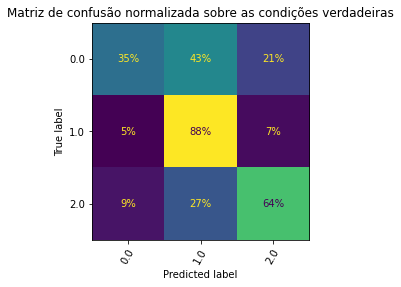

In [19]:
imprimeMatrizDeConfusão(y_test, xgb_preds, xgb_model)

#### GB: Busca de melhores hiper parâmetros

In [36]:
def treinar_modelo_gb(params):
    learning_rate = params[0]
    max_depth = params[1]
    min_child_weight = params[2]
    gamma = params[3]
    colsample_bytree = params[4]
    
    print(params, '\n')
    
    gb_Model = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, min_child_weight=min_child_weight, colsample_bytree=colsample_bytree,
                             use_label_encoder=False, random_state=0, n_jobs=-1)
    gb_Model.fit(X_train, y_train_ordinal)
    
    gb_preds = gb_Model.predict(X_test)
    
    return -accuracy_score(y_test_ordinal, gb_preds)*100

space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (2, 16), # max_depth
         (1, 16), # min_child_weight
         (0.0, 0.5), # gamma
         (0.1, 1.0)] # colsample bytree

In [ ]:
# learning_rate=0.0576, max_depth=16, min_child_weight=1, gamma=0.0, colsample_bytree=0.6166650768689715, use_label_encoder=False, random_state=0, n_jobs=-1
def treinar_modelo_gb(params):
    learning_rate = params[0]
    max_depth = params[1]
    min_child_weight = params[2]
    gamma = params[3]
    colsample_bytree = params[4]
    
    print(params, '\n')
    
    gb_Model = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, min_child_weight=min_child_weight, colsample_bytree=colsample_bytree,
                             use_label_encoder=False, random_state=0, n_jobs=-1)
    gb_Model.fit(X_train, y_train_ordinal)
    
    gb_preds = gb_Model.predict(X_test)
    
    return -accuracy_score(y_test_ordinal, gb_preds)*100

space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (16, 32), # max_depth
         (1, 16), # min_child_weight
         (0.0, 0.5), # gamma
         (0.1, 1.0)] # colsample bytree

In [ ]:
resultados_gb = gp_minimize(treinar_modelo_gb, space, random_state=0, verbose=1, n_calls=30, n_random_starts=10, n_jobs=-1)

In [44]:
resultados_gb.x

[0.0576181277900256, 16, 1, 0.0, 0.6166650768689715]

In [46]:
# Melhores hiper parâmetros para o conjunto PRO: learning_rate=0.0576, max_depth=16, min_child_weight=1, gamma=0.0, colsample_bytree=0.6166650768689715, use_label_encoder=False, random_state=0, n_jobs=-1

In [47]:
# Melhores hiper parâmetros para o conjunto PNP: 

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

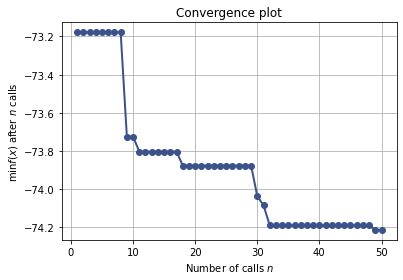

In [42]:
from skopt.plots import plot_convergence
plot_convergence(resultados_gb)

### SVM

In [21]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state = 0)

In [ ]:
%%time
svc_model = SVC(kernel='linear', cache_size=5000, random_state=0) # Linear Kernel

svc_model.fit(X_train, y_train)

svc_preds = svc_model.predict(X_test)

In [ ]:
print("Acurácia:", accuracy_score(y_test, svc_preds))

###  Gaussian Naive Bayes

In [80]:
# Conjunto com todas as classes
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [81]:
from sklearn.naive_bayes import GaussianNB

In [82]:
gnb_model = GaussianNB()
gnb_preds = gnb_model.fit(X_train, y_train).predict(X_test)
print("Acurácia:", accuracy_score(y_test, gnb_preds))

Acurácia: 0.556987377131262


### Logistic Regression

In [70]:
# Conjunto de dados PNP: Pastejando x Não Pastejando
y_pnp = y
y_pnp = y_pnp.replace(to_replace=['Agua', 'Locomovendo', 'Ocio', 'Outros','Ruminando'], value='Não Pastejando')
X_train, X_test, y_train, y_test = train_test_split(X, y_pnp, random_state = 0)

In [71]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train, y_train)

In [86]:
lr_preds = lr_model.predict(X_test)

In [87]:
print("Acurácia:", accuracy_score(y_test, lr_preds))

Acurácia: 0.6389042612064195


### Redes Neurais

In [128]:
from sklearn.neural_network import MLPClassifier

In [134]:
rn_model = MLPClassifier(hidden_layer_sizes=(8,8,8), early_stopping=True, max_iter=400, verbose=True, random_state=0)
rn_model.fit(X_train, y_train)

Iteration 1, loss = 0.66244527
Validation score: 0.644509
Iteration 2, loss = 0.63292880
Validation score: 0.660759
Iteration 3, loss = 0.62147511
Validation score: 0.667018
Iteration 4, loss = 0.61348418
Validation score: 0.667260
Iteration 5, loss = 0.60835299
Validation score: 0.673386
Iteration 6, loss = 0.60411985
Validation score: 0.682346
Iteration 7, loss = 0.60063661
Validation score: 0.685443
Iteration 8, loss = 0.59835031
Validation score: 0.687529
Iteration 9, loss = 0.59629142
Validation score: 0.687726
Iteration 10, loss = 0.59447342
Validation score: 0.691723
Iteration 11, loss = 0.59307875
Validation score: 0.693458
Iteration 12, loss = 0.59193036
Validation score: 0.696313
Iteration 13, loss = 0.59095015
Validation score: 0.695171
Iteration 14, loss = 0.58977233
Validation score: 0.694995
Iteration 15, loss = 0.58894464
Validation score: 0.694907
Iteration 16, loss = 0.58815113
Validation score: 0.694864
Iteration 17, loss = 0.58744785
Validation score: 0.693634
Iterat

MLPClassifier(early_stopping=True, hidden_layer_sizes=(8, 8, 8), max_iter=400,
              random_state=0, verbose=True)

In [135]:
rn_preds = rn_model.predict(X_test)

In [136]:
print("Acurácia:", accuracy_score(y_test, rn_preds)*100)

Acurácia: 70.54773763406857


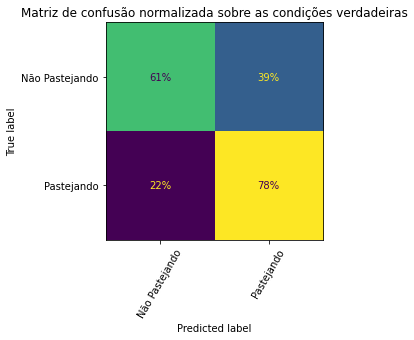

In [137]:
imprimeMatrizDeConfusão(y_test, rn_preds, rn_model)

#### RN: Busca de melhores hiper parâmetros 

### KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier

In [17]:
knn_model = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10)

In [18]:
knn_preds = knn_model.predict(X_test)

print("Acurácia:", accuracy_score(y_test, knn_preds))

Acurácia: 0.7347155242838697


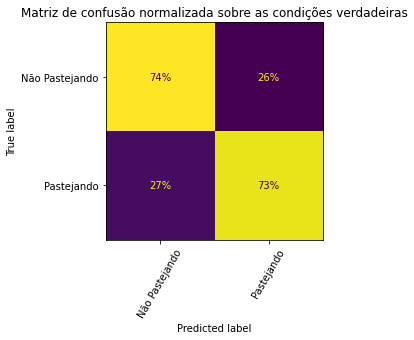

In [19]:
imprimeMatrizDeConfusão(y_test, knn_preds, knn_model)

### Teste de RF em CV

In [22]:
from sklearn.model_selection import cross_val_score

def get_score(n_estimators):
    clf = RandomForestClassifier(n_estimators, random_state=0, n_jobs=-1)
    scores = cross_val_score(clf, X_train, y_train, cv=3)
    return scores.mean()


In [14]:
results = {} 
n_estimators = 100
while n_estimators < 250:
    n_estimators += 50
    results[n_estimators] = get_score(n_estimators)

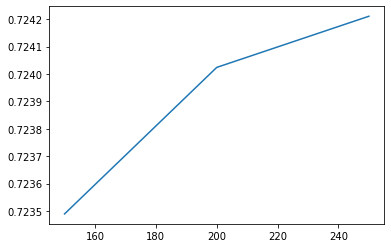

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

### Leave One Group Out

In [14]:
from sklearn.model_selection import LeaveOneGroupOut

In [15]:
df = pd.read_csv(caminho_dados_lazaro)

#### Leave One Animal Out

In [16]:
groups = np.array(df.Animal.values)

In [17]:
loao = LeaveOneGroupOut()
loao.get_n_splits(X, y, groups)

9

In [18]:
df = df[features_aplicaveis]

y = df.Comportamento
X = df.drop('Comportamento', axis=1)

X = np.array(X)
y = np.array(y)

In [21]:
cv = loao.split(X, y, groups)
model = RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=0)
scores = np.array

In [138]:
%%time
for train_index, test_index in cv:
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    model.fit(X_train, y_train.ravel())
    preds = model.predict(X_test)
    scores.append(accuracy_score(y_test, preds)*100)

CPU times: user 19min 26s, sys: 7.76 s, total: 19min 34s
Wall time: 5min 12s


In [143]:
scores.mean()

49.57656849471909

##### Vizualização

In [26]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
y = enc.fit_transform(y.array.reshape(-1, 1))

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

np.random.seed(0)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

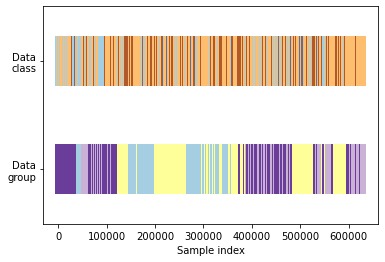

In [108]:
def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


visualize_groups(y, groups, "no groups")

### Lidando com dados desbalanceados

In [62]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
import seaborn as sns

In [18]:
df.Comportamento.value_counts()

Pastejando    332512
Ruminando     151381
Ocio          123257
Name: Comportamento, dtype: int64

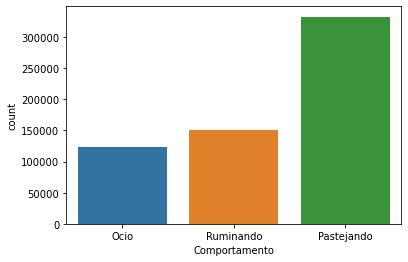

In [20]:
ax = sns.countplot(x="Comportamento", data=df)

In [22]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=150,
                              min_samples_split=30,
                              min_samples_leaf=1,
                              max_features='sqrt',
                              max_depth=100,
                              criterion='entropy',
                              bootstrap=False,
                              n_jobs=-1,
                              random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [23]:
accuracy_score(y_test, preds)*100

74.09413128837589

In [24]:
print (classification_report(y_test, preds))

              precision    recall  f1-score   support

        Ocio       0.65      0.43      0.52     30838
  Pastejando       0.77      0.89      0.83     83380
   Ruminando       0.70      0.67      0.68     37570

    accuracy                           0.74    151788
   macro avg       0.71      0.66      0.68    151788
weighted avg       0.73      0.74      0.73    151788



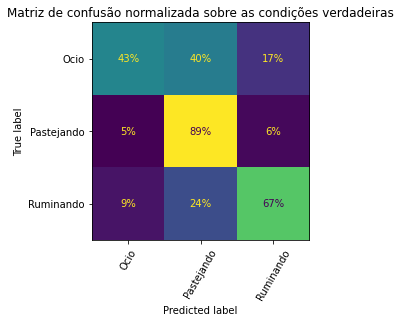

In [26]:
imprimeMatrizDeConfusão(y_test, preds, model)

#### Aplicando NearMiss

In [27]:
nr = NearMiss()

In [29]:
X, y = nr.fit_resample(X, y)

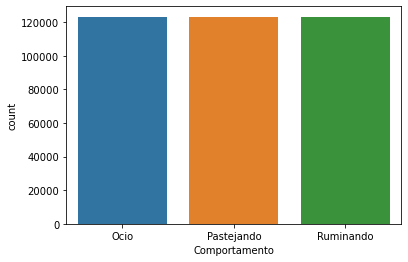

In [30]:
ax = sns.countplot(x=y)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [38]:
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [39]:
accuracy_score(y_test, preds)*100

68.94086085479701

In [40]:
print (classification_report(y_test, preds))

              precision    recall  f1-score   support

        Ocio       0.66      0.61      0.64     30976
  Pastejando       0.70      0.73      0.72     30906
   Ruminando       0.70      0.73      0.72     30561

    accuracy                           0.69     92443
   macro avg       0.69      0.69      0.69     92443
weighted avg       0.69      0.69      0.69     92443



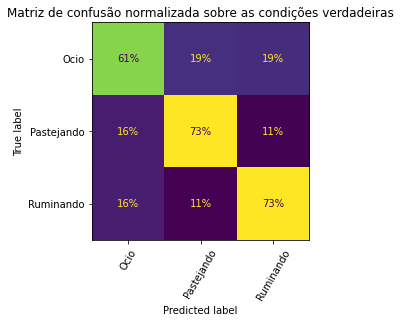

In [41]:
imprimeMatrizDeConfusão(y_test, preds, model)

#### Aplicando o SMOTE

In [78]:
X = df.drop("Comportamento", axis = 1)
y = df.Comportamento

In [79]:
# Visualizando a quantidade de dados por classe
y.value_counts()

Pastejando    332512
Ruminando     151381
Ocio          123257
Name: Comportamento, dtype: int64

In [80]:
smt = SMOTE()

In [81]:
X, y = smt.fit_resample(X, y)

In [60]:
# Visualizando a quantidade de dados por classe
y.value_counts()

Ocio          332512
Ruminando     332512
Pastejando    332512
Name: Comportamento, dtype: int64

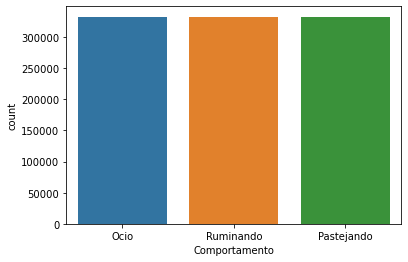

In [63]:
ax = sns.countplot(x=y)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [65]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=150,
                              min_samples_split=30,
                              min_samples_leaf=1,
                              max_features='sqrt',
                              max_depth=100,
                              criterion='entropy',
                              bootstrap=False,
                              n_jobs=-1,
                              random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [66]:
accuracy_score(y_test, preds)*100

76.60595707824078

In [67]:
print (classification_report(y_test, preds))

              precision    recall  f1-score   support

        Ocio       0.76      0.72      0.74     83256
  Pastejando       0.75      0.80      0.77     83127
   Ruminando       0.79      0.78      0.78     83001

    accuracy                           0.77    249384
   macro avg       0.77      0.77      0.77    249384
weighted avg       0.77      0.77      0.77    249384



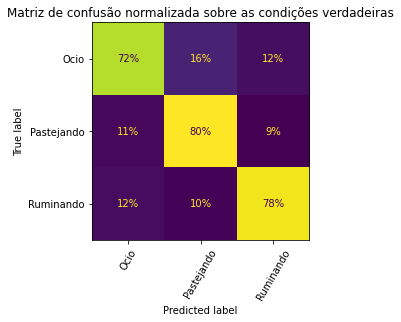

In [69]:
imprimeMatrizDeConfusão(y_test, preds, model)